## Imports

In [1]:
from ragas.testset import TestsetGenerator

import os
import openai

from openai import OpenAI

client = OpenAI()

/opt/anaconda3/envs/ragas/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from llama_index import download_loader, SimpleDirectoryReader


In [3]:
import matplotlib.pyplot as plt

## Assessing current state of test date generation

In [63]:
!pwd

/Users/shahules/belar/experimental


In [27]:

ArxivReader = download_loader("ArxivReader")

loader = ArxivReader() #uses simpledirectory reader under the hood, hence need modification to laod pages properly

In [4]:
# documents = loader.load_data("retrieval augmented generation AND large language model",max_results=20,papers_dir='./arxiv-papers')

In [4]:
reader = SimpleDirectoryReader("./arxiv-papers/",num_files_limit=20)
documents = reader.load_data()

## SimpleDirectoryReader?

In [6]:
len(documents)

131

In [7]:
# print(documents[14].get_metadata_str())
# print("CONTENT")
# print(documents[14].get_content())
# print(len(documents[14].get_content().split(' ')))

(array([ 5.,  3.,  6., 13., 28., 21., 39., 10.,  5.,  1.]),
 array([  10. ,  113.1,  216.2,  319.3,  422.4,  525.5,  628.6,  731.7,
         834.8,  937.9, 1041. ]),
 <BarContainer object of 10 artists>)

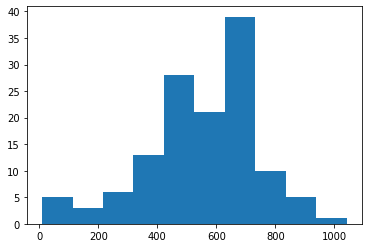

In [8]:
plt.hist([len(doc.get_content().split()) for doc in documents])

In [21]:
test_dist =  {
    "simple": 0.3,
    "reasoning": 0.25,
    "multi_context": .2,
    "conditional": 0.25,
}

In [22]:
testsetgenerator = TestsetGenerator.from_default(testset_distribution=test_dist,chunk_size=512)


In [7]:
!pwd

/Users/shahules/belar/experimental


In [ ]:
test_df = testsetgenerator.generate(documents,test_size=50)

  0%|                                                            | 0/50 [00:00<?, ?it/s]

Len of text chunks 2 403
seed question ['What are the pillars of the Security Architecture Principles?', 'Why is it important to assign the least privilege possible?']


sequence item 0: expected str instance, ReadTimeoutError found


{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


sequence item 0: expected str instance, ReadTimeoutError found


{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


  2%|█                                                   | 1/50 [00:32<26:32, 32.49s/it]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


  6%|███                                                 | 3/50 [00:52<12:21, 15.78s/it]

Len of text chunks 3 405
seed question ['What is the purpose of maintaining the Security Division ecosystem?', 'How are the diagrams in the Security Division ecosystem created and maintained?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


 12%|██████▏                                             | 6/50 [01:19<08:31, 11.62s/it]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


 20%|██████████▏                                        | 10/50 [01:35<05:01,  7.54s/it]

Len of text chunks 2 328
Len of text chunks 3 460
seed question ['What is the expected response when a team is assigned an S1 or S2 security issue?', 'How should non-vulnerability security issues be handled by the security team?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


 30%|███████████████▎                                   | 15/50 [03:55<10:16, 17.61s/it]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question is clear', 'verdict': 'Yes'}


 42%|█████████████████████▍                             | 21/50 [04:23<05:38, 11.68s/it]

Len of text chunks 2 472
Len of text chunks 4 503
Len of text chunks 2 351
seed question ['What are some potential causes of workplace conflict?', 'How can conflict be managed and resolved in the workplace?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question is clear', 'verdict': 'Yes'}


 56%|████████████████████████████▌                      | 28/50 [04:58<03:12,  8.76s/it]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


 72%|████████████████████████████████████▋              | 36/50 [05:16<01:25,  6.09s/it]

Len of text chunks 1 284
seed question ['Why is a security sales training program important for Field Security?', 'What are the objectives of the security sales enablement program?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


 90%|█████████████████████████████████████████████▉     | 45/50 [05:31<00:21,  4.30s/it]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


55it [05:40,  3.01s/it]                                                                 

Len of text chunks 1 186
seed question ['What is the goal of the Ecommerce Motion working group?', 'Where can the Google Doc for the Ecommerce Motion working group be accessed?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


66it [06:04,  2.68s/it]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


78it [06:30,  2.48s/it]

Len of text chunks 7 117
Len of text chunks 3 354
Len of text chunks 3 487
Len of text chunks 1 310
seed question ['What are some of the actions suggested to improve design discussions?', 'Who supported UX Research in conducting user interviews?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': "The question mentions a 'given context' but does not provide what that context is", 'verdict': 'No'}
{'reason': "The question mentions 'UX Research' and 'user interviews' but does not specify in what context or project, making it unclear", 'verdict': 'No'}
rewritten question Who supported UX Research in conducting user interviews in the UX department?
{'reason': "The question mentions 'UX Research' and 'UX department' but it is not clear which organization or context this refers to", 'verdict': 'No'}
Len of text chunks 3 435
Len of text chunks 1 191
Len of text chunks 1 248
Len of text chunks 3 475
Len of text chunks 3 488
Len of text chunks 

91it [07:50,  3.83s/it]

Len of text chunks 1 229
seed question ['What is Vendorpedia used for?', 'How can GitLab team members access AnswerBase?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


105it [08:14,  3.08s/it]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


120it [08:33,  2.42s/it]

Len of text chunks 3 407
seed question ['What measures has GitLab taken to address the concern of an economic downturn?', 'How does GitLab address the concern of a pandemic like COVID-19?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question is clear', 'verdict': 'Yes'}


136it [09:11,  2.41s/it]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


153it [09:48,  2.33s/it]

Len of text chunks 2 355
seed question ['Are FAQs considered unstructured content?', 'What is the recommended method for announcing important decisions in a distributed organization?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


171it [09:59,  1.74s/it]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


190it [10:08,  1.31s/it]

Len of text chunks 2 481
seed question ['When should threat modeling be done in the development process?', 'What is the purpose of threat modeling?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question is clear', 'verdict': 'Yes'}


210it [10:36,  1.34s/it]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'Each question can be understood without additional context', 'verdict': 'Yes'}


231it [11:03,  1.31s/it]

Len of text chunks 2 367
seed question ['What are the benefits of using SOCIAL STYLES?', 'How can the SOCIAL STYLES framework enhance team performance?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


253it [11:35,  1.36s/it]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


276it [11:59,  1.25s/it]

Len of text chunks 3 432
seed question ['What are the roles and responsibilities of the working group in automotive software development?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question is clear', 'verdict': 'Yes'}


300it [12:31,  1.29s/it]

Len of text chunks 2 497
seed question ['What is the purpose of having cadences in a company?', 'How do cadences at GitLab differ from each other?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': "The question mentions 'this cadence' which is not specified, making it unclear", 'verdict': 'No'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


325it [13:12,  1.40s/it]

Len of text chunks 1 294
Len of text chunks 4 333
Len of text chunks 5 462
Len of text chunks 3 264
Len of text chunks 4 478
Len of text chunks 2 359
seed question ['What is the purpose of the Security Shadow Program?', 'Who can join the Security Shadow Program?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


351it [13:53,  1.46s/it]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


378it [14:09,  1.17s/it]

Len of text chunks 2 458
seed question ['What is the purpose of the New Hire Security Training?', 'Who is responsible for approving significant changes and exceptions to this standard?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question is clear', 'verdict': 'Yes'}


406it [14:44,  1.20s/it]

{'reason': "The question is unclear without specifying what 'standard' is being referred to", 'verdict': 'No'}
rewritten question Who is responsible for approving significant changes and exceptions to the standard outlined in the Roles & Responsibilities section?
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


435it [15:01,  1.01s/it]

Len of text chunks 3 259
Len of text chunks 1 241
seed question ["What are the benefits of GitLab's user access review?"]
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question is too specific and requires additional context', 'verdict': 'No'}
Len of text chunks 4 445
seed question ['What are the procedures followed by TPRM engineers for vendors accessing or being transmitted different classifications of GitLab data?', 'When should TPRM engineers perform additional Security review or validation?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


465it [16:05,  1.37s/it]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


496it [16:35,  1.24s/it]

Len of text chunks 3 433
Len of text chunks 1 193
seed question ['What are the business goals of the Learning Experience Working Group?', 'How will the Learning Experience Working Group determine if Field Enablement and Learning & Development use cases can be met by the Professional Services Learning Experience Platform?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


528it [16:51,  1.00it/s]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


561it [16:57,  1.36it/s]

Len of text chunks 3 381
Len of text chunks 4 450
seed question ['What are KPIs?', 'Where are the Sales KPIs documented?']
{'reason': 'The question is clear', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


595it [17:30,  1.23it/s]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


630it [17:49,  1.38it/s]

Len of text chunks 1 303
Len of text chunks 3 483


/Users/shahules/belar/src/ragas/testset/utils.py:16: UserWarning: Invalid json
  warnings.warn("Invalid json")


seed question []
Len of text chunks 2 354
seed question ['What are some common criticisms of Open Core?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


666it [18:05,  1.57it/s]

Len of text chunks 2 503
seed question ['What should be done to begin a security incident investigation?', 'How should artifacts from an investigation be handled?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


703it [18:59,  1.11it/s]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


741it [19:30,  1.15it/s]

Len of text chunks 4 275
seed question ["What is the highest level in GitLab's organizational structure?", "How many layers are there in GitLab's organizational structure?"]
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question is clear', 'verdict': 'Yes'}


780it [19:56,  1.24it/s]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


820it [20:14,  1.44it/s]

Len of text chunks 2 500
Len of text chunks 3 462
Len of text chunks 2 354
seed question ['What are the advantages of using a single application in GitLab?', 'How does increasing Stages per Organization drive revenue in GitLab?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The questions can be understood without additional context', 'verdict': 'Yes'}


861it [21:02,  1.18it/s]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


903it [21:29,  1.28it/s]

Len of text chunks 2 351
Len of text chunks 2 275
seed question ['What is the purpose of coaching in an all-remote organization?', 'How does coaching facilitate the career development of team members?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}


946it [27:04,  3.00s/it]

{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question is clear', 'verdict': 'Yes'}


990it [27:33,  2.26s/it]

Len of text chunks 2 350
Len of text chunks 2 506
seed question ['What is the purpose of having stable counterparts in Product Groups?', 'Why does GitLab avoid having internal platform groups?']
{'reason': 'The question can be understood without additional context', 'verdict': 'Yes'}
{'reason': 'The question is clear', 'verdict': 'Yes'}


In [ ]:
test_df.to_pandas()

In [ ]:
test_df.to_pandas().to_csv("gitlab_3wh_50.csv")

In [51]:
x = [1,2,3]

In [52]:
x.index(4)

ValueError: 4 is not in list

In [50]:
test_df

NameError: name 'test_df' is not defined

**Observations**
- Conditional question evol is working
- reasoning/multi context are not working as expected
- Almost all questions are closed endeded 
- Almost all questions start with "What"

## Experiments

In [13]:
from llama_index.readers.file.markdown_reader import MarkdownReader
from llama_index.schema import Document
from typing import List, Dict, Optional
from pathlib import Path
import re
import os

In [14]:
class RagasMdReader(MarkdownReader):
    
    @staticmethod
    def get_file_metadata(path):
        
        return {"file_name":os.path.basename(path),
                "dirname":os.path.dirname(path)}
        
    
    def get_local_metadata(self, text):
        

        return_dict = {}
        pattern = r'---\s*title:\s*(.+?)(?:\s*description:\s*"(.*?)")?\s*---'
        match = re.findall(pattern, text)
        if match:
            title,desc = match[0]
            return_dict['title'] = title
            return_dict['description'] = desc if desc else None
            
        return return_dict

        
    
        
    
    def load_data(
        self, file: Path, extra_info: Optional[Dict] = None
    ) -> List[Document]:
        """Parse file into string."""
        
        with open(file, "r", encoding="utf-8") as f:
            content = f.read()
        if self._remove_hyperlinks:
            content = self.remove_hyperlinks(content)
        if self._remove_images:
            content = self.remove_images(content)
            
        local_metadata = self.get_local_metadata(content)

        extra_info = dict(extra_info,**local_metadata) if local_metadata else extra_info
        return [Document(text=content,metadata=extra_info)]
        
        


In [15]:
md_reader = RagasMdReader(remove_hyperlinks=False)

In [16]:
def llm2(prompt, **kwargs):
    response = client.chat.completions.create(
        model=kwargs.get("model", "gpt-3.5-turbo"),
        messages=[{"role": "system", "content": prompt}],
        temperature=kwargs.get("temperature", 0),
        top_p=kwargs.get("top_p", 1),
        frequency_penalty=kwargs.get("frequency_penalty", 0.0),
        presence_penalty=kwargs.get("presence_penalty", 0.0),
        max_tokens=kwargs.get("max_tokens", 500),
        n=kwargs.get("n", 1),
    )
    return response

In [17]:
from ragas.testset.prompts import SEED_QUESTION, EVOLUTION_ELIMINATION, REWRITE_QUESTION, FILTER_QUESTION

In [18]:
# !ls /Users/shahules/Myprojects/rag-experiments/gitlab-handbook/data/handbook/

In [19]:
dirs = [
    "/Users/shahules/Myprojects/rag-experiments/gitlab-handbook/data/handbook/leadership/",
    "/Users/shahules/Myprojects/rag-experiments/gitlab-handbook/data/handbook/company/",
    "/Users/shahules/Myprojects/rag-experiments/gitlab-handbook/data/handbook/infrastructure-standards/",
    "/Users/shahules/Myprojects/rag-experiments/gitlab-handbook/data/handbook/communication/",
    "/Users/shahules/Myprojects/rag-experiments/gitlab-handbook/data/handbook/security"
]
documents = []
for dir_path in dirs:
    loader = SimpleDirectoryReader(dir_path, 
                                   recursive=True,
                                  file_extractor={".md":md_reader},
                                file_metadata=RagasMdReader.get_file_metadata)
    
    documents.extend(loader.load_data())

In [20]:
len([doc for doc in documents if doc.metadata.get("file_name") is None ])

0

In [78]:
import re

# Sample text
text = """
---
title: "Ask Me Anything"
description: "Learn and ask questions at GitLab's Ask Me Anything (AMA) meetings"
---
"""

# Regular expression to capture title and description
pattern_optional_description = '---\s*title:\s*(.+?)(?:\s*description:\s*"(.*?)")?\s*---'

# Finding matches
matches = re.match(pattern_optional_description, text)

matches


In [79]:
matches is None

True

In [72]:
pattern = re.compile('---\s*title:\s*(.+?)(?:\s*description:\s*"(.*?)")?\s*---')
[m.groupdict() for m in pattern.finditer(text)]

[{}]

In [68]:
text = """
---
title: "Book clubs"
---

From time to time, we run internal book clubs on a book from one of our resource lists. All are welcome! However,
each club has a suggested audience to indicate roles to which the content is tailored.

- [Leadership]({{< ref "_index.md#books" >}})
- [Development](https://about.gitlab.com/handbook/engineering/development/#books)
"""

In [60]:
pattern_optional_description = r'---\s*title:\s*"(.+?)"\s*---'
re.findall(pattern,text)

[]

In [39]:
len(documents)

168

In [13]:
# documents[0].metadata

In [5]:
testset = testsetgenerator.generate(documents, test_size=50)


In [13]:
testset.to_pandas().to_csv("gitlab_communication_company_v2.csv")

In [4]:
# testset.to_pandas()

In [20]:
q1="How should I use my notification settings in Slack?"
q2="What's the best way to manage Slack notification settings for efficient communication and minimal disruptions?"


In [21]:
prompt = EVOLUTION_ELIMINATION.prompt.template.format(question1=q1, question2=q2)

## Create multi context
- find similar docs using metadata 


In [116]:
from langchain.embeddings import OpenAIEmbeddings
from llama_index.indices.query.embedding_utils import get_top_k_embeddings

In [103]:
model = OpenAIEmbeddings()

In [112]:
titles = [doc.metadata.get('title').strip('"') for doc in documents if doc.metadata]

In [114]:
embeddings = model.embed_documents(titles)

In [170]:
k=24

In [171]:
scores, indices = get_top_k_embeddings(embeddings[k],embeddings,similarity_cutoff=0.8)

In [172]:
print(f"Seach query :{titles[k]}\n Results: [{[titles[i] for i in indices[:5]]}")

Seach query :Top Cross-Functional Initiatives
 Results: [['Top Cross-Functional Initiatives', 'Building High Performing Teams', 'Product Career Development Framework Working Group', 'Leadership', 'Single Codebase Working Group']


## Merge documents based on meta-data

In [13]:
from langchain.prompts import HumanMessagePromptTemplate


In [14]:
REWRITE_QUESTION = HumanMessagePromptTemplate.from_template("""
Rewrite the given question so that it can be answered without context.

Question: When was he born?
Context : Albert Einstein was a German-born theoretical physicist who is widely held to be one of the greatest and most influential scientists of all time. He was born on 14 March 1879.
Rewritten question: When was Albert Einstein born? 

Context: A clothes iron (also flatiron, smoothing iron, or simply iron) is a small appliance that, when heated, is used to press clothes to remove wrinkles and unwanted creases. Domestic irons generally range in operating temperature from between 121 °C (250 °F) to 182 °C (360 °F). It is named for the metal (iron) of which the device was historically made, and the use of it is generally called ironing, the final step in the process of laundering clothes.
Question: What is temperate range of the device?
Rewritten question: What is temperate range of clothes iron?


Question:{question}
Context: {context}
Rewritten question:
""")

QUERY =  HumanMessagePromptTemplate.from_template("""
Rewrite the question using given context so that it can be read and answered without any extra information.

Question:{question}
Context: {context}
""")

text = """
The Mona Lisa, painted by Leonardo da Vinci in the early 16th century, is one of the most famous and valuable paintings in the world.
Known for its enigmatic expression and innovative use of sfumato, the painting has become a symbol of Renaissance art.
The Mona Lisa is displayed in the Louvre Museum in Paris and attracts millions of visitors annually.
"""

In [15]:
def get_content(indices):
    
    return '\n'.join([documents[idx].get_content() for idx in indices])

In [26]:
# documents[50]

In [29]:
response = llm2(SEED_QUESTION.format(context=get_content([49,50])).content)

In [30]:
q = response.choices[0].message.content
q

'What is the purpose of the GPT-3 Editor in the CORE framework?'

In [82]:
print(QUERY.format(question=q, context=get_content([12,13,14])).content)
print('Rewritten question: How does the size of the training data affect the performance of the SELF-RAG model according to the experiment results?')


Rewrite the question using given context so that it can be read and answered without any extra information.

Question:What is the impact of training data size on the model's performance?
Context: Preprint.
Table 2: Overall experiment results on six tasks. Bold numbers indicate the best performance among
non-proprietary models, and gray-colored bold text indicates the best proprietary model when
they outperforms all non-proprietary models.∗indicates concurrent or recent results reported by
concurrent work. – indicates numbers that are not reported by the original papers or are not applicable.
Models are sorted based on scale. FS, em, rg, mau, prec, rec denote FactScore (factuality); str-em,
rouge (correctness); MAUVE (fluency); citation precision and recall, respectively.
Short-form Closed-set Long-form generations (with citations)
PopQA TQA Pub ARC Bio ASQA
LM (acc) (acc) (acc) (acc) (FS) (em) (rg) (mau) (pre) (rec)
LMs with proprietary data
Llama2-c 13B 20.0 59.3 49.4 38.4 55.9 22.4 

In [79]:
len(get_content([12,13,14]).split())

1909

In [45]:
print(get_content([14]))

Stimuli BMS [41] Pan et al. [29] Salicon [15] ML-Net [9] Ours Ground Truth
Figure 3: Qualitative performance comparison .
SateliteJumbledSocial
OutdoorNaturalArt
InvertedFractalObjectCartoon
OutdoorManMadeIndoorActionPatternNoisy
Affective
BlackWhiteRandom
LowResolutionLineDrawingSketchSketchLineDrawingLowResolutionRandomBlackWhiteAffectiveNoisyPatternActionIndoorOutdoorManMadeCartoonObjectFractalInvertedArtOutdoorNaturalSocialJumbledSatelite
0.00.20.40.60.81.0
Figure 4: Classiﬁcation confusion matrix .
bias. Location bias is an important component of human
visual attention, and so should be included in any model.
Table 2 shows the results of the 5-fold cross validation
tests on the CAT2000 dataset. We achieve the best perfor-
mance of the tested models. Table 3 shows the performance
on the held out test images. Our model achieves the second
best performance behind the DeepFix model [22]. Com-
pared with DeepFix our network is shallower with less pa-
rameters. The DeepFix model is not 

In [69]:
from llama_index.node_parser.simple import SimpleNodeParser
node_parser = SimpleNodeParser.from_defaults(
            chunk_size=1000, chunk_overlap=0, include_metadata=True
        )

In [70]:
nodes = node_parser.get_nodes_from_documents(
            documents=documents
        )

In [83]:
nodes[1].metadata

{'page_label': '2',
 'file_name': '00891b5a3dbbe4dae6b06432c3f335f8.pdf',
 'file_path': 'arxiv-papers/00891b5a3dbbe4dae6b06432c3f335f8.pdf',
 'creation_date': '2023-11-14',
 'last_modified_date': '2023-11-14',
 'last_accessed_date': '2023-11-14'}

In [84]:
x = [1,2,3,4,5]

In [91]:
x[0:2]

[1, 2]

## Data cleaning

In [1]:
import pandas as pd

In [8]:
df = pd.read_csv("/Users/shahules/Downloads/gitlab_communication_company_v2.csv")

In [10]:
df.columns

Index(['Unnamed: 0', 'seed_question', 'question', 'context', 'answer',
       'question_type', 'episode_done', 'evolution_elimination'],
      dtype='object')

In [16]:
# df = df.drop(['Unnamed: 0','seed_question','evolution_elimination'],axis=1)
df['question'] = df['question'].apply(lambda x : x.replace("Casual Rewrite:",""))

In [18]:
df.to_csv("gitlab_company_v1.csv")

In [9]:
x = [1,2,3,5]

In [10]:
x[::-1]

[5, 3, 2, 1]

In [15]:
question="What is the percentage of repetition in the generations produced by RETRO compared to GPT across different sizes?"

In [18]:
response = llm2(FILTER_QUESTION.format(question=question).content)